In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics as skm
from sklearn import svm
from sklearn.model_selection import train_test_split

# 1. Data Processing

The data in this assignment comes from the UC Irvine Machine Learning library.

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)

The data here doesn't have column names. They have to be added manually. The list of names comes from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names).

In [3]:
cols = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'native_country',
    'salary'
]

df.columns = cols

Check the shape of the dataframe and print out a few rows to confirm everything looks good.

In [4]:
df.shape

(32561, 15)

In [5]:
# Unnecessary column
df.drop(columns='fnlwgt', inplace=True)

# Revalue the target variable
df.salary.replace({'<=50K':0, '>50K':1}, inplace=True)

In [6]:
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
X = df.drop(columns='salary')
y = df.salary

In [8]:
print(X.shape)
print(y.shape)

(32561, 13)
(32561,)


In [9]:
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(X_test.shape)

(22792, 107)
(9769, 107)


# 2. Random Forest Classifier - Base Model:

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_test_rf_pred  = rf.predict(X_test)
y_test_rf_proba = rf.predict_proba(X_test)

print("Random Forest Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_rf_pred))
print("\nRandom Forest Test Classification Report")
print(skm.classification_report(y_test, y_test_rf_pred))
print("\nRandom Forest Test ROC AUC")
print(skm.roc_auc_score(y_test, y_test_rf_proba[:,1]))

Random Forest Test Confusion Matrix
[[6831  577]
 [ 955 1406]]

Random Forest Test Classification Report
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      7408
          1       0.71      0.60      0.65      2361

avg / total       0.84      0.84      0.84      9769


Random Forest Test ROC AUC
0.870716422737007


Text(0,0.5,'Feature Importance')

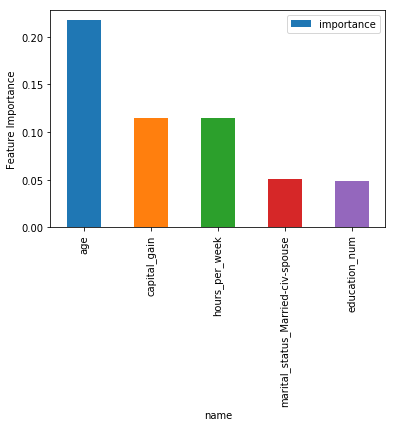

In [13]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': rf.feature_importances_})
fi = fi.sort_values('importance', ascending=False).head(5)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

## Overfitting 

Is there overfitting in this model? Random Forest is prone to overfitting. If the train accuracy and ROC AUC score are much higher than the test scores it is an indicator of overfitting.

In [14]:
y_train_rf_pred  = rf.predict(X_train)
y_train_rf_proba = rf.predict_proba(X_train)

print("Train Score:", round(rf.score(X_train, y_train), 2))
print("\nTrain Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_rf_pred))
print("\nTrain Classification Report")
print(skm.classification_report(y_train, y_train_rf_pred))
print("\nTrain ROC AUC")
print(skm.roc_auc_score(y_train, y_train_rf_proba[:,1]))
print("")

Train Score: 0.97

Train Confusion Matrix
[[17102   210]
 [  478  5002]]

Train Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     17312
          1       0.96      0.91      0.94      5480

avg / total       0.97      0.97      0.97     22792


Train ROC AUC
0.9958430115138901



The RandomForest train score is much much higher than the test score. The train ROC is almost 1. The data has practically been memorized. There is definite overfitting happening in the RandomForest classifier.

# 3. AdaBoost Classifier - GridSearch

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2,0.4,0.6,0.8,1, 1.2],
    'random_state' : [123]
}

abc = AdaBoostClassifier()

grid_search_abc = GridSearchCV(abc, parameters, cv=5, scoring='roc_auc',refit=True, n_jobs=-1, verbose=1)

grid_search_abc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min


In [ ]:
abc_best = grid_search_abc.best_estimator_

y_test_abc_pred  = abc_best.predict(X_test)
y_test_abc_proba = abc_best.predict_proba(X_test)

print("\nAdaBoost Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_abc_pred))
print("\nAdaBoost Test Classification Report")
print(skm.classification_report(y_test, y_test_abc_pred))
print("\nAdaBoost Test ROC AUC")
print(skm.roc_auc_score(y_test, y_test_abc_proba[:,1]))
print("")

In [ ]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': abc_best.feature_importances_})
fi = fi.sort_values('importance', ascending=False).head(5)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

## Overfitting 

Is there overfitting in this model?

In [ ]:
y_train_abc_pred  = abc_best.predict(X_train)
y_train_abc_proba = abc_best.predict_proba(X_train)

In [ ]:
print("\nAdaBoost Train Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_abc_pred))
print("\nAdaBoost Train Classification Report")
print(skm.classification_report(y_train, y_train_abc_pred))
print("\nAdaBoost Train ROC AUC")
print(skm.roc_auc_score(y_train, y_train_abc_proba[:,1]))
print("")

Surprisingly not! The slow learning method of boosting seems to have aleviated much of the problems regarding overfitting. The train AUC and precision are almost exactly the same as test.

# 4. Gradient Boosting Classifier - GridSearch

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2,0.6,1.0],
    'max_depth': [1,2],
    'random_state' : [123]
}

gbc = GradientBoostingClassifier()

grid_search_gbc = GridSearchCV(gbc, parameters, cv=5, scoring='roc_auc',refit=True, n_jobs=-1, verbose=1)

grid_search_gbc.fit(X_train, y_train)

In [ ]:
gbc_best = grid_search_gbc.best_estimator_

In [ ]:
y_test_gbc_pred  = gbc_best.predict(X_test)
y_test_gbc_proba = gbc_best.predict_proba(X_test)

In [ ]:
print("Gradient Boosting Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_gbc_pred))
print("\nGradient Boosting Test Classification Report")
print(skm.classification_report(y_test, y_test_gbc_pred))
print("\nGradient Boosting Test ROC AUC")
print(skm.roc_auc_score(y_test, y_test_gbc_proba[:,1]))
print("")

In [ ]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': gbc_best.feature_importances_})
fi = fi.sort_values('importance', ascending=False).head(5)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

## Overfitting

Is there overfitting with this model?

In [ ]:
y_train_gbc_pred  = gbc_best.predict(X_train)
y_train_gbc_proba = gbc_best.predict_proba(X_train)

print("Gradient Boosting Train Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_gbc_pred))
print("\nnGradient Boosting Train Classification Report")
print(skm.classification_report(y_train, y_train_gbc_pred))
print("\nnGradient Boosting Train ROC AUC")
print(skm.roc_auc_score(y_train, y_train_gbc_proba[:,1]))
print("")

Again, no! The boosting algorthims do not seem to lead to overfitting the way that RandomForest does. This is a significant improvment over that ensemble method.

# Conceptual Problems: 

**5) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.**

The alpha paramter in AdaBoost is the weight of that an individual predictor contributes to the ensemble model. The more accurate the predictor is the higher the weight it will get. The predictor weight is based on accuracy of the simple model, and also on the learning rate. A low learning rate will lead to a slower convergence on accuracy and more overall predictors with each predictor contributing less to the ensemble.

**6) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.**

Once all the predictors are trained and predictor weights determined, the model is ready to determine classes. It does this by running the test data through all the predictors in the model. Each weak learner outputs a class and the classes are weighted by the predictor weight, the alpha parameter. The class with a weighted majority wins.

**7) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?**

The max_depth parameter is the depth of the individual trees. Generally the lower the better. The point of boosting is to combine the results of many weak learners to produce a strong learner. Trees with only a few nodes are weak and are only marginally better than random guessing. This is good for a boosting algorithm. Choosing the number of splits in the individual trees controls the amount of learning we allow from those trees. With a greater depth you probably need fewer trees in your algorithm, so it is a parameter that controls the rate of learning. Will your algorithm learn very slowly or very quickly? With a larger number of splits you can learn more quickly which might be preferred on a large dataset even if you sacrifice some accuracy.

**8) In Part (e) of Steps 2-4 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).**

Many of the same variables show up as top 5 predictors in all three models. Age is one that stands out to me. This makes sense because older people tend to make more. They have worked more years at their jobs and have amassed more industry knowledge. They have progress further up the corporate ladder. It makes complete sense that this would be a top predictor of salary.

**9) From the models run in steps 2-4, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.**

Gradient Boosting performed the best of all the models run. It significantly outperformed RandomForest, achieiving an 87% test precision and a 92.8 test AUC ROC score. It only marginally outperformed AdaBoost to the point that I would say those two models tied. Both AdaBoost and Gradient Boosting had very high AUC ROC scores, very high precision, and low difference between train and test. However Gradient has a very very small advantage over AdaBoost on this dataset.

**10) For your best performing model, plot out an ROC curve. Feel free to use sklearn, matplotlib or any other method in python.**

In [ ]:
fpr, tpr, threshold = skm.roc_curve(y_test, y_test_gbc_proba[:,1])
roc_auc = skm.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(fpr, tpr)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')